# получение дескрипторов для всех сиквенсов по всему датасету

In [ ]:
!pip install biopython -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

# from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [ ]:
df = pd.read_csv("/content/tcell_full_v3_processed.csv")

df['Host'] = df['Host'].fillna("Unknown")
df = df[df['Host'].str.contains("Homo sapiens", case=False)]

# df_10 = df[['Epitope ID', 'Epitope Seq', 'IL-10 release']]
# df_10 = df_10[df_10['IL-10 release'].notna()]

In [ ]:
# https://web.expasy.org/protparam/protparam-doc.html

df['molecular_weight'] = df['Epitope Seq'].apply(lambda x: ProteinAnalysis(x).molecular_weight())
df['aromaticity'] = df['Epitope Seq'].apply(lambda x: ProteinAnalysis(x).aromaticity())

df['ss_helix'] = df['Epitope Seq'].apply(lambda x: ProteinAnalysis(x).secondary_structure_fraction()[0])
df['ss_turn'] = df['Epitope Seq'].apply(lambda x: ProteinAnalysis(x).secondary_structure_fraction()[1])
df['ss_sheet'] = df['Epitope Seq'].apply(lambda x: ProteinAnalysis(x).secondary_structure_fraction()[2])

df['isoelectric_point'] = df['Epitope Seq'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())

# GRAVY (Grand Average of Hydropathy)
df['gravy'] = df['Epitope Seq'].apply(lambda x: ProteinAnalysis(x).gravy())

# molar_extinction_coefficient
df['molar_extinction'] = df['Epitope Seq'].apply(lambda x: ProteinAnalysis(x).molar_extinction_coefficient())

In [ ]:
# https://www.sciencedirect.com/science/article/abs/pii/S1046202323001135?via%3Dihub

# pseudo-amino acid composition (PAAC), GetPAAC
# amphiphilic pseudo-amino acid composition (APAAC), GetAPAAC
# quasi-sequence-order (QSO),

# Shannon entropy

In [ ]:
!pip install propy3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.3/290.3 kB 11.8 MB/s eta 0:00:00


In [ ]:
from propy import PyPro

In [ ]:
df.columns

Index(['MHC Allele', 'Evidence Code', 'MHC Class', 'Epitope ID', 'Epitope Seq',
       'Host', 'Antigen Source', 'IL-2 release', 'IL-4 release',
       'IL-10 release', 'IFNg release', 'molecular_weight', 'aromaticity',
       'ss_helix', 'ss_turn', 'ss_sheet', 'isoelectric_point', 'gravy',
       'molar_extinction'],
      dtype='object')

In [ ]:
def get_PAAC(sequence):
  DesObject = PyPro.GetProDes(sequence)
  paac = DesObject.GetPAAC(lamda=6, weight=0.05)
  return list(paac.values())

df['PAAC'] = df['Epitope Seq'].apply(get_PAAC)

paac_length = len(df['PAAC'].iloc[0])

paac_columns = [f'PAAC_{i}' for i in range(paac_length)]

paac_expanded = pd.DataFrame(df['PAAC'].tolist(),
                                   index=df.index,
                                   columns=paac_columns)

df = pd.concat([df[['Epitope ID',
                          'Epitope Seq',
                          'IL-2 release',
                          'IL-4 release',
                          'IL-10 release',
                          'IFNg release',

                          'molecular_weight',
                          'aromaticity',
                          'ss_helix',
                          'ss_turn',
                          'ss_sheet',
                          'isoelectric_point',
                          'gravy',
                          'molar_extinction',]], paac_expanded], axis=1)

In [ ]:
df.head(2)

,Epitope ID,Epitope Seq,IL-2 release,IL-4 release,IL-10 release,IFNg release,molecular_weight,aromaticity,ss_helix,ss_turn,...,PAAC_16,PAAC_17,PAAC_18,PAAC_19,PAAC_20,PAAC_21,PAAC_22,PAAC_23,PAAC_24,PAAC_25
0,57415,SEFAYGSFVRTVSL,NaN,NaN,NaN,1.0,1562.7204,0.214286,0.214286,0.285714,...,4.266,0.000,4.266,8.532,8.140,7.471,5.590,9.066,4.097,5.915
2,42795,MTEQQWNFAGIEAAAS,NaN,1.0,NaN,NaN,1753.8857,0.125000,0.437500,0.187500,...,4.029,4.029,0.000,0.000,5.267,5.012,6.269,6.981,5.263,6.746


In [ ]:
df.to_csv('all_paac_temp.csv')

In [ ]:
df = pd.read_csv('/content/all_paac_temp.csv')

In [ ]:
def get_APAAC(sequence):
  DesObject = PyPro.GetProDes(sequence)
  DesDescr = DesObject.GetAPAAC(lamda=6, weight=0.05)
  return list(DesDescr.values())


df['APAAC'] = df['Epitope Seq'].apply(get_APAAC)

apaac_length = len(df['APAAC'].iloc[0])
apaac_columns = [f'APAAC_{i}' for i in range(apaac_length)]
apaac_expanded = pd.DataFrame(df['APAAC'].tolist(),
                                   index=df.index,
                                   columns=apaac_columns)

df = pd.concat([df, apaac_expanded], axis=1)
df.head(2)

,Unnamed: 0,Epitope ID,Epitope Seq,IL-2 release,IL-4 release,IL-10 release,IFNg release,molecular_weight,aromaticity,ss_helix,...,APAAC_22,APAAC_23,APAAC_24,APAAC_25,APAAC_26,APAAC_27,APAAC_28,APAAC_29,APAAC_30,APAAC_31
0,0,57415,SEFAYGSFVRTVSL,NaN,NaN,NaN,1.0,1562.7204,0.214286,0.214286,...,-1.971,-1.083,1.448,0.354,-1.294,-0.067,1.314,0.128,0.452,-0.195
1,2,42795,MTEQQWNFAGIEAAAS,NaN,1.0,NaN,NaN,1753.8857,0.125000,0.437500,...,0.933,0.409,0.187,-0.964,-0.658,-0.757,0.798,0.301,-1.446,-1.622


In [ ]:
df.to_csv('all_paac_apaac.csv')

In [ ]:
df = pd.read_csv('/content/all_paac_apaac.csv')

In [ ]:
def get_QSO(sequence):
  DesObject = PyPro.GetProDes(sequence)
  DesDescr = DesObject.GetQSO()
  return list(DesDescr.values())


df['QSO'] = df['Epitope Seq'].apply(get_QSO)

qso_length = len(df['QSO'].iloc[0])
qso_columns = [f'QSO_{i}' for i in range(qso_length)]
qso_expanded = pd.DataFrame(df['QSO'].tolist(),
                                   index=df.index,
                                   columns=qso_columns)

df = pd.concat([df, qso_expanded], axis=1)
df.head(2)

,Unnamed: 0.1,Unnamed: 0,Epitope ID,Epitope Seq,IL-2 release,IL-4 release,IL-10 release,IFNg release,molecular_weight,aromaticity,...,QSO_90,QSO_91,QSO_92,QSO_93,QSO_94,QSO_95,QSO_96,QSO_97,QSO_98,QSO_99
0,0,0,57415,SEFAYGSFVRTVSL,NaN,NaN,NaN,1.0,1562.7204,0.214286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,42795,MTEQQWNFAGIEAAAS,NaN,1.0,NaN,NaN,1753.8857,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from scipy.stats import entropy

In [ ]:
# Функция для расчета энтропии Шеннона
def shannon_entropy(sequence):
    # Подсчет частоты каждой аминокислоты
    freq = pd.Series(list(sequence)).value_counts(normalize=True)
    # Рассчет энтропии Шеннона
    return -np.sum(freq * np.log2(freq))

# Применение функции ко всем последовательностям в колонке
df['shannon_entropy'] = df['Epitope Seq'].apply(shannon_entropy)

# Вывод результата
print(df[['Epitope Seq', 'shannon_entropy']])

              Epitope Seq  shannon_entropy
0          SEFAYGSFVRTVSL         3.182006
1        MTEQQWNFAGIEAAAS         3.250000
2        AAASAIQGNVTSIHSL         3.077820
3        NVTSIHSLLDEGKQSL         3.405639
4        LDEGKQSLTKLAAAWG         3.155639
...                   ...              ...
14123  GTLNNVVEKERKFLKQFL         3.197160
14124  GTRLPAIPKNVKKEPLVM         3.419382
14125  GVFLPKYAKQNGGNVDKT         3.419382
14126  GVTSLVSCGSSCLLSCVM         2.621353
14127  GWMIRSSGFLISLQKYRP         3.461320

[14128 rows x 2 columns]


In [ ]:
df

In [ ]:
df.to_csv('all_descr.csv')

In [ ]:
df = pd.read_csv('/content/all_descr.csv')
df.shape[0]

14128

# удаление дубликатов сиквенсов (надо было сделать это раньше)

In [ ]:
df = df[(df['IL-10 release'].notna())]
df.shape[0]

932

In [ ]:
df = df.drop_duplicates(subset='Epitope Seq')
df.shape[0]

932

In [ ]:
df.drop(columns=['QSO'], inplace=True)
df.shape[0]

932

In [ ]:
df.to_csv('all_descr_without_duplicates.csv')

# обучение

In [26]:
!pip install lightautoml -U

  Using cached lightautoml-0.4.1-py3-none-any.whl.metadata (13 kB)
  Using cached autowoe-1.3.3-py3-none-any.whl.metadata (2.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.

In [36]:
%pip install pandas imbalanced-learn matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
TARGET_NAME = 'IL-10 release'

In [315]:
import pandas as pd
train_df = pd.read_csv('/Users/rleontiev/Downloads/Telegram Desktop/il10_train.csv').sort_values(by='Epitope ID')
train_y = train_df[TARGET_NAME]
test_df = pd.read_csv('/Users/rleontiev/Downloads/Telegram Desktop/il10_test.csv').sort_values(by='Epitope ID')
test_y = test_df[TARGET_NAME]

In [316]:
train_df

,Epitope ID,MHC Allele,Evidence Code,MHC Class,Epitope Seq,Host,Antigen Source,IL-2 release,IL-4 release,IL-10 release,IFNg release
83,888,HLA class II,Single allele present,II,AEERADIAESQVNKLRAK,Homo sapiens (human),Homo sapiens,NaN,NaN,1.0,1.0
773,5320,HLA class II,T cell assay -T cell subset identification,II,AVFEAALTKAITAMS,Homo sapiens (human),Phleum pratense,NaN,1.0,0.0,NaN
740,8399,HLA-DR,Cited reference,II,DGGSILKISNKYHTK,Homo sapiens (human),Betula pendula,NaN,1.0,1.0,1.0
538,8930,HLA-DR,Cited reference,II,DKLKQQRDTLSTQKET,Homo sapiens (human),Streptococcus pyogenes,NaN,1.0,1.0,1.0
240,10269,HLA-DR,Statistically inferred by motif or alleles pre...,II,DSVTPMILKAQKGGNL,Homo sapiens (human),Canis lupus,NaN,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
833,2233349,HLA class II,T cell assay -T cell subset identification,II,NIDGYFKIYSKHTPINLV,Homo sapiens (human),Severe acute respiratory syndrome coronavirus 2,NaN,NaN,0.0,0.0
436,2238281,HLA-DPA1*02:02/DPB1*05:01,MHC binding assay,II,DKSMKVTVAFNQF,Homo sapiens (human),Cryptomeria japonica,1.0,NaN,1.0,NaN
17,2269069,HLA-DR15,Cited reference,II,FLLHHAFVDSIFEQWLQRHRP,Homo sapiens (human),Homo sapiens,NaN,NaN,0.0,NaN
543,2269374,HLA-DR11,Cited reference,II,TSYVKVLHHMVKISG,Homo sapiens (human),Homo sapiens,NaN,NaN,0.0,NaN


In [317]:
all_df = pd.read_csv('/Users/rleontiev/Downloads/Telegram Desktop/features_human_cytokine.csv').sort_values(by='Epitope ID')

In [318]:
all_df

,Epitope ID,Moreau-Broto_Auto_MBAuto_CIDH920105_1,Moreau-Broto_Auto_MBAuto_CIDH920105_2,Moreau-Broto_Auto_MBAuto_CIDH920105_3,Moreau-Broto_Auto_MBAuto_CIDH920105_4,Moreau-Broto_Auto_MBAuto_CIDH920105_5,Moreau-Broto_Auto_MBAuto_CIDH920105_6,Moreau-Broto_Auto_MBAuto_CIDH920105_7,Moreau-Broto_Auto_MBAuto_CIDH920105_8,Moreau-Broto_Auto_MBAuto_CIDH920105_9,...,QSO_97,QSO_98,QSO_99,shannon_entropy,molar_extinction_reduced,flexibility,instability_index,Hydrophobic Moment,Boman,MS-WHIM
2262,29,0.188983,0.335746,0.450658,0.649392,0.793122,0.885213,0.914524,1.041162,1.292689,...,0.0,0.0,0.0,3.446439,0,1.014657,4.835000,0.325786,0.711000,1031.562561
8866,39,0.281813,0.596036,0.953489,1.297521,1.688596,2.160669,2.724423,3.433578,4.360832,...,0.0,0.0,0.0,2.682589,0,0.990044,8.933333,0.157444,-0.254000,717.850291
4484,46,0.020947,0.054307,0.191502,0.340707,0.508782,0.587770,0.539570,0.613145,0.542841,...,0.0,0.0,0.0,2.682589,0,0.995159,16.513333,0.412295,0.026000,735.893541
2,60,-0.245354,-0.445723,-0.666538,-0.941086,-1.095475,-1.382599,-1.632492,-1.831190,-2.209876,...,0.0,0.0,0.0,3.077820,0,1.000527,6.475000,0.320969,0.164375,770.409896
804,61,-0.136385,-0.420870,-0.646164,-0.811573,-0.898015,-1.115934,-1.273519,-1.491801,-1.793890,...,0.0,0.0,0.0,2.706891,0,1.006250,23.486667,0.276554,0.866667,765.430291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41292,2270776,0.293405,0.576362,1.086273,1.858974,2.647398,3.533246,4.601058,6.100668,7.843729,...,0.0,0.0,0.0,3.189898,6990,0.965196,124.873333,0.278074,2.506000,938.531211
41287,2270777,0.291379,0.571029,0.911281,1.262918,1.578233,1.888806,2.306298,2.932467,3.533812,...,0.0,0.0,0.0,3.461320,2980,0.982638,15.283333,0.509844,0.678333,1118.068655
41293,2270779,-0.194652,-0.397718,-0.615231,-0.824286,-1.091001,-1.397698,-1.739588,-2.037785,-2.319942,...,0.0,0.0,0.0,3.403989,0,0.989971,96.695238,0.612526,0.306667,1244.069699
41289,2270786,-0.222909,-0.416274,-0.574186,-0.662357,-0.857433,-1.006743,-1.070539,-1.217096,-1.465845,...,0.0,0.0,0.0,3.308271,5500,1.002589,9.400000,0.480024,0.734444,965.541436


In [319]:
# descriptors_train = descriptors_train[descriptors_train['Epitope ID'].isin(train_df['Epitope ID'])]

In [320]:
train_df = all_df[all_df['Epitope ID'].isin(train_df['Epitope ID'])]
test_df = all_df[all_df['Epitope ID'].isin(test_df['Epitope ID'])]

In [322]:
train_df[TARGET_NAME] = train_y.to_list()
test_df[TARGET_NAME] = test_y.to_list()

/var/folders/3m/ml853yhj7m1gwt_yly8mfyd40000gp/T/ipykernel_76283/2824089339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[TARGET_NAME] = train_y.to_list()
/var/folders/3m/ml853yhj7m1gwt_yly8mfyd40000gp/T/ipykernel_76283/2824089339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET_NAME] = test_y.to_list()


In [8]:
train_df

,Epitope ID,Moreau-Broto_Auto_MBAuto_CIDH920105_1,Moreau-Broto_Auto_MBAuto_CIDH920105_2,Moreau-Broto_Auto_MBAuto_CIDH920105_3,Moreau-Broto_Auto_MBAuto_CIDH920105_4,Moreau-Broto_Auto_MBAuto_CIDH920105_5,Moreau-Broto_Auto_MBAuto_CIDH920105_6,Moreau-Broto_Auto_MBAuto_CIDH920105_7,Moreau-Broto_Auto_MBAuto_CIDH920105_8,Moreau-Broto_Auto_MBAuto_CIDH920105_9,...,QSO_98,QSO_99,shannon_entropy,molar_extinction_reduced,flexibility,instability_index,Hydrophobic Moment,Boman,MS-WHIM,IL-10 release
3865,888,0.052586,0.107602,0.165454,0.271932,0.437479,0.588578,0.849816,1.287230,1.667607,...,0.0,0.0,3.239098,0,1.021741,59.188889,0.440078,3.586111,1014.545236,1.0
3526,5320,-0.247516,-0.458980,-0.697038,-0.988353,-1.184568,-1.401998,-1.682071,-2.114232,-2.537360,...,0.0,0.0,2.999581,0,0.991843,38.626667,0.342119,-0.490667,762.410516,0.0
17234,8399,0.073013,0.118453,0.180685,0.243500,0.372710,0.474580,0.474594,0.741879,1.252689,...,0.0,0.0,3.189898,1490,1.013089,38.066667,0.446569,1.969333,830.954471,1.0
3031,8930,0.461405,0.904821,1.361863,1.837785,2.296789,2.745736,3.418948,4.375279,5.450154,...,0.0,0.0,2.858459,0,1.022022,6.162500,0.293016,4.606875,960.013251,1.0
1841,10269,0.277079,0.659350,1.034084,1.397027,1.778584,2.167702,2.626678,3.192112,3.998377,...,0.0,0.0,3.625000,0,1.003694,15.225000,0.406050,0.820625,836.458531,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22948,2233349,-0.257475,-0.609654,-0.947556,-1.224186,-1.513605,-1.868819,-2.278560,-2.763566,-3.424730,...,0.0,0.0,3.572431,2980,0.998353,11.883333,0.448731,0.909444,1061.570196,0.0
23002,2238281,-0.357738,-0.642834,-1.098742,-1.532485,-2.056411,-2.712961,-3.436806,-4.268320,-5.378240,...,0.0,0.0,3.238901,0,0.985003,-21.961538,0.293419,1.520769,757.887216,1.0
41281,2269069,0.141566,0.291212,0.461266,0.655329,0.829899,1.111197,1.319390,1.710763,2.033959,...,0.0,0.0,3.522572,5500,0.980331,60.452381,0.528518,1.763333,1338.700921,0.0
41279,2269374,-0.027840,-0.140901,-0.116901,-0.004301,0.185758,0.322459,0.480251,0.681034,0.928461,...,0.0,0.0,3.189898,1490,0.961044,-5.826667,0.560156,0.312000,849.971611,0.0


In [9]:
import pandas as pd
# from transformers import BertModel, BertTokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

Matplotlib is building the font cache; this may take a moment.


'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/Users/rleontiev/Downloads/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/rleontiev/Downloads/.venv/lib/python3.9/site-packages/lightautoml/ml_algo/dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/Users/rleontiev/Downloads/.venv/lib/python3.9/site-packages/lightautoml/text/embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/Users/rleontiev/Downloads/.venv/lib/python3.9/site-packages/lightautoml/text/dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [323]:
print(train_df.shape)
train_df = train_df[train_df['IL-10 release'].notna()]
train_df = train_df.drop(columns=['Epitope ID'])
print(train_df.shape)

print(test_df.shape)
test_df = test_df[test_df['IL-10 release'].notna()]
test_df = test_df.drop(columns=['Epitope ID'])
print(test_df.shape)

(842, 1425)
(842, 1424)
(211, 1425)
(211, 1424)


In [324]:
X_train = train_df.drop(columns=[TARGET_NAME])
y_train = train_df[TARGET_NAME]

In [325]:
from imblearn.combine import SMOTEENN

sm = SMOTEENN(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)

/Users/rleontiev/Downloads/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/rleontiev/Downloads/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/rleontiev/Downloads/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [326]:
y_sm.value_counts()

IL-10 release
1.0    460
0.0    267
Name: count, dtype: int64

In [327]:
train_df_sm = pd.concat([X_sm, y_sm], axis=1)

In [328]:
train_df_sm

,Moreau-Broto_Auto_MBAuto_CIDH920105_1,Moreau-Broto_Auto_MBAuto_CIDH920105_2,Moreau-Broto_Auto_MBAuto_CIDH920105_3,Moreau-Broto_Auto_MBAuto_CIDH920105_4,Moreau-Broto_Auto_MBAuto_CIDH920105_5,Moreau-Broto_Auto_MBAuto_CIDH920105_6,Moreau-Broto_Auto_MBAuto_CIDH920105_7,Moreau-Broto_Auto_MBAuto_CIDH920105_8,Moreau-Broto_Auto_MBAuto_CIDH920105_9,Moreau-Broto_Auto_MBAuto_CIDH920105_10,...,QSO_98,QSO_99,shannon_entropy,molar_extinction_reduced,flexibility,instability_index,Hydrophobic Moment,Boman,MS-WHIM,IL-10 release
0,-0.247516,-0.458980,-0.697038,-0.988353,-1.184568,-1.401998,-1.682071,-2.114232,-2.537360,-3.105603,...,0.0,0.0,2.999581,0,0.991843,38.626667,0.342119,-0.490667,762.410516,0.0
1,-0.435029,-0.938094,-1.515046,-2.146953,-2.838099,-3.666608,-4.704047,-6.058222,-7.532305,-9.410705,...,0.0,0.0,2.789898,0,0.999575,4.066667,0.621039,0.009333,808.474496,0.0
2,-0.643499,-1.297115,-1.960400,-2.642419,-3.284955,-3.971724,-4.838621,-5.969394,-7.318954,-9.024634,...,0.0,0.0,3.506891,8480,0.978958,31.840000,0.530589,1.168000,922.935423,0.0
3,-0.231740,-0.411501,-0.575452,-0.825064,-1.133651,-1.519391,-2.121368,-2.693612,-3.139587,-3.783623,...,0.0,0.0,3.375000,12490,1.004959,40.950000,0.454416,3.518750,1053.013581,0.0
4,-0.273661,-0.547162,-0.856290,-1.222933,-1.678339,-2.091370,-2.467595,-2.988031,-3.617448,-4.711265,...,0.0,0.0,3.506891,2980,0.994915,24.100000,0.444740,0.940000,879.442548,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,0.010741,-0.013710,0.001179,0.139333,0.298064,0.577583,0.938874,1.436869,2.110252,2.936607,...,0.0,0.0,3.328303,0,1.001395,15.026461,0.412392,1.150671,862.953177,1.0
723,0.288735,0.652404,1.073654,1.600480,2.135252,2.868976,3.656780,4.508843,5.502014,7.103096,...,0.0,0.0,3.189898,0,1.003494,25.048046,0.478408,0.572824,866.787223,1.0
724,0.066591,0.104847,0.149154,0.225399,0.314839,0.411869,0.588479,0.774573,0.971571,1.109832,...,0.0,0.0,3.312219,1490,0.986472,57.074160,0.512554,0.908385,1219.538933,1.0
725,0.179550,0.404423,0.648166,0.921636,1.173871,1.434076,1.738064,2.137404,2.735357,3.304968,...,0.0,0.0,3.442201,0,1.001444,16.842025,0.449818,1.031168,839.367438,1.0


In [329]:
value_counts = train_df_sm['IL-10 release'].value_counts()

print("Количество каждого уникального значения в столбце IL-10 release на train_df:")
print(value_counts)

Количество каждого уникального значения в столбце IL-10 release на train_df:
IL-10 release
1.0    460
0.0    267
Name: count, dtype: int64


In [300]:
value_counts = test_df['IL-10 release'].value_counts()

print("Количество каждого уникального значения в столбце IL-10 release на test_df:")
print(value_counts)

Количество каждого уникального значения в столбце IL-10 release на test_df:
IL-10 release
0.0    147
1.0     64
Name: count, dtype: int64


In [301]:
N_THREADS = 1
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900

In [64]:
task = Task('binary')
# task = Task('reg')

In [65]:

roles = {
    'target': TARGET_NAME
}

In [302]:
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    selection_params={'mode': 2}
)

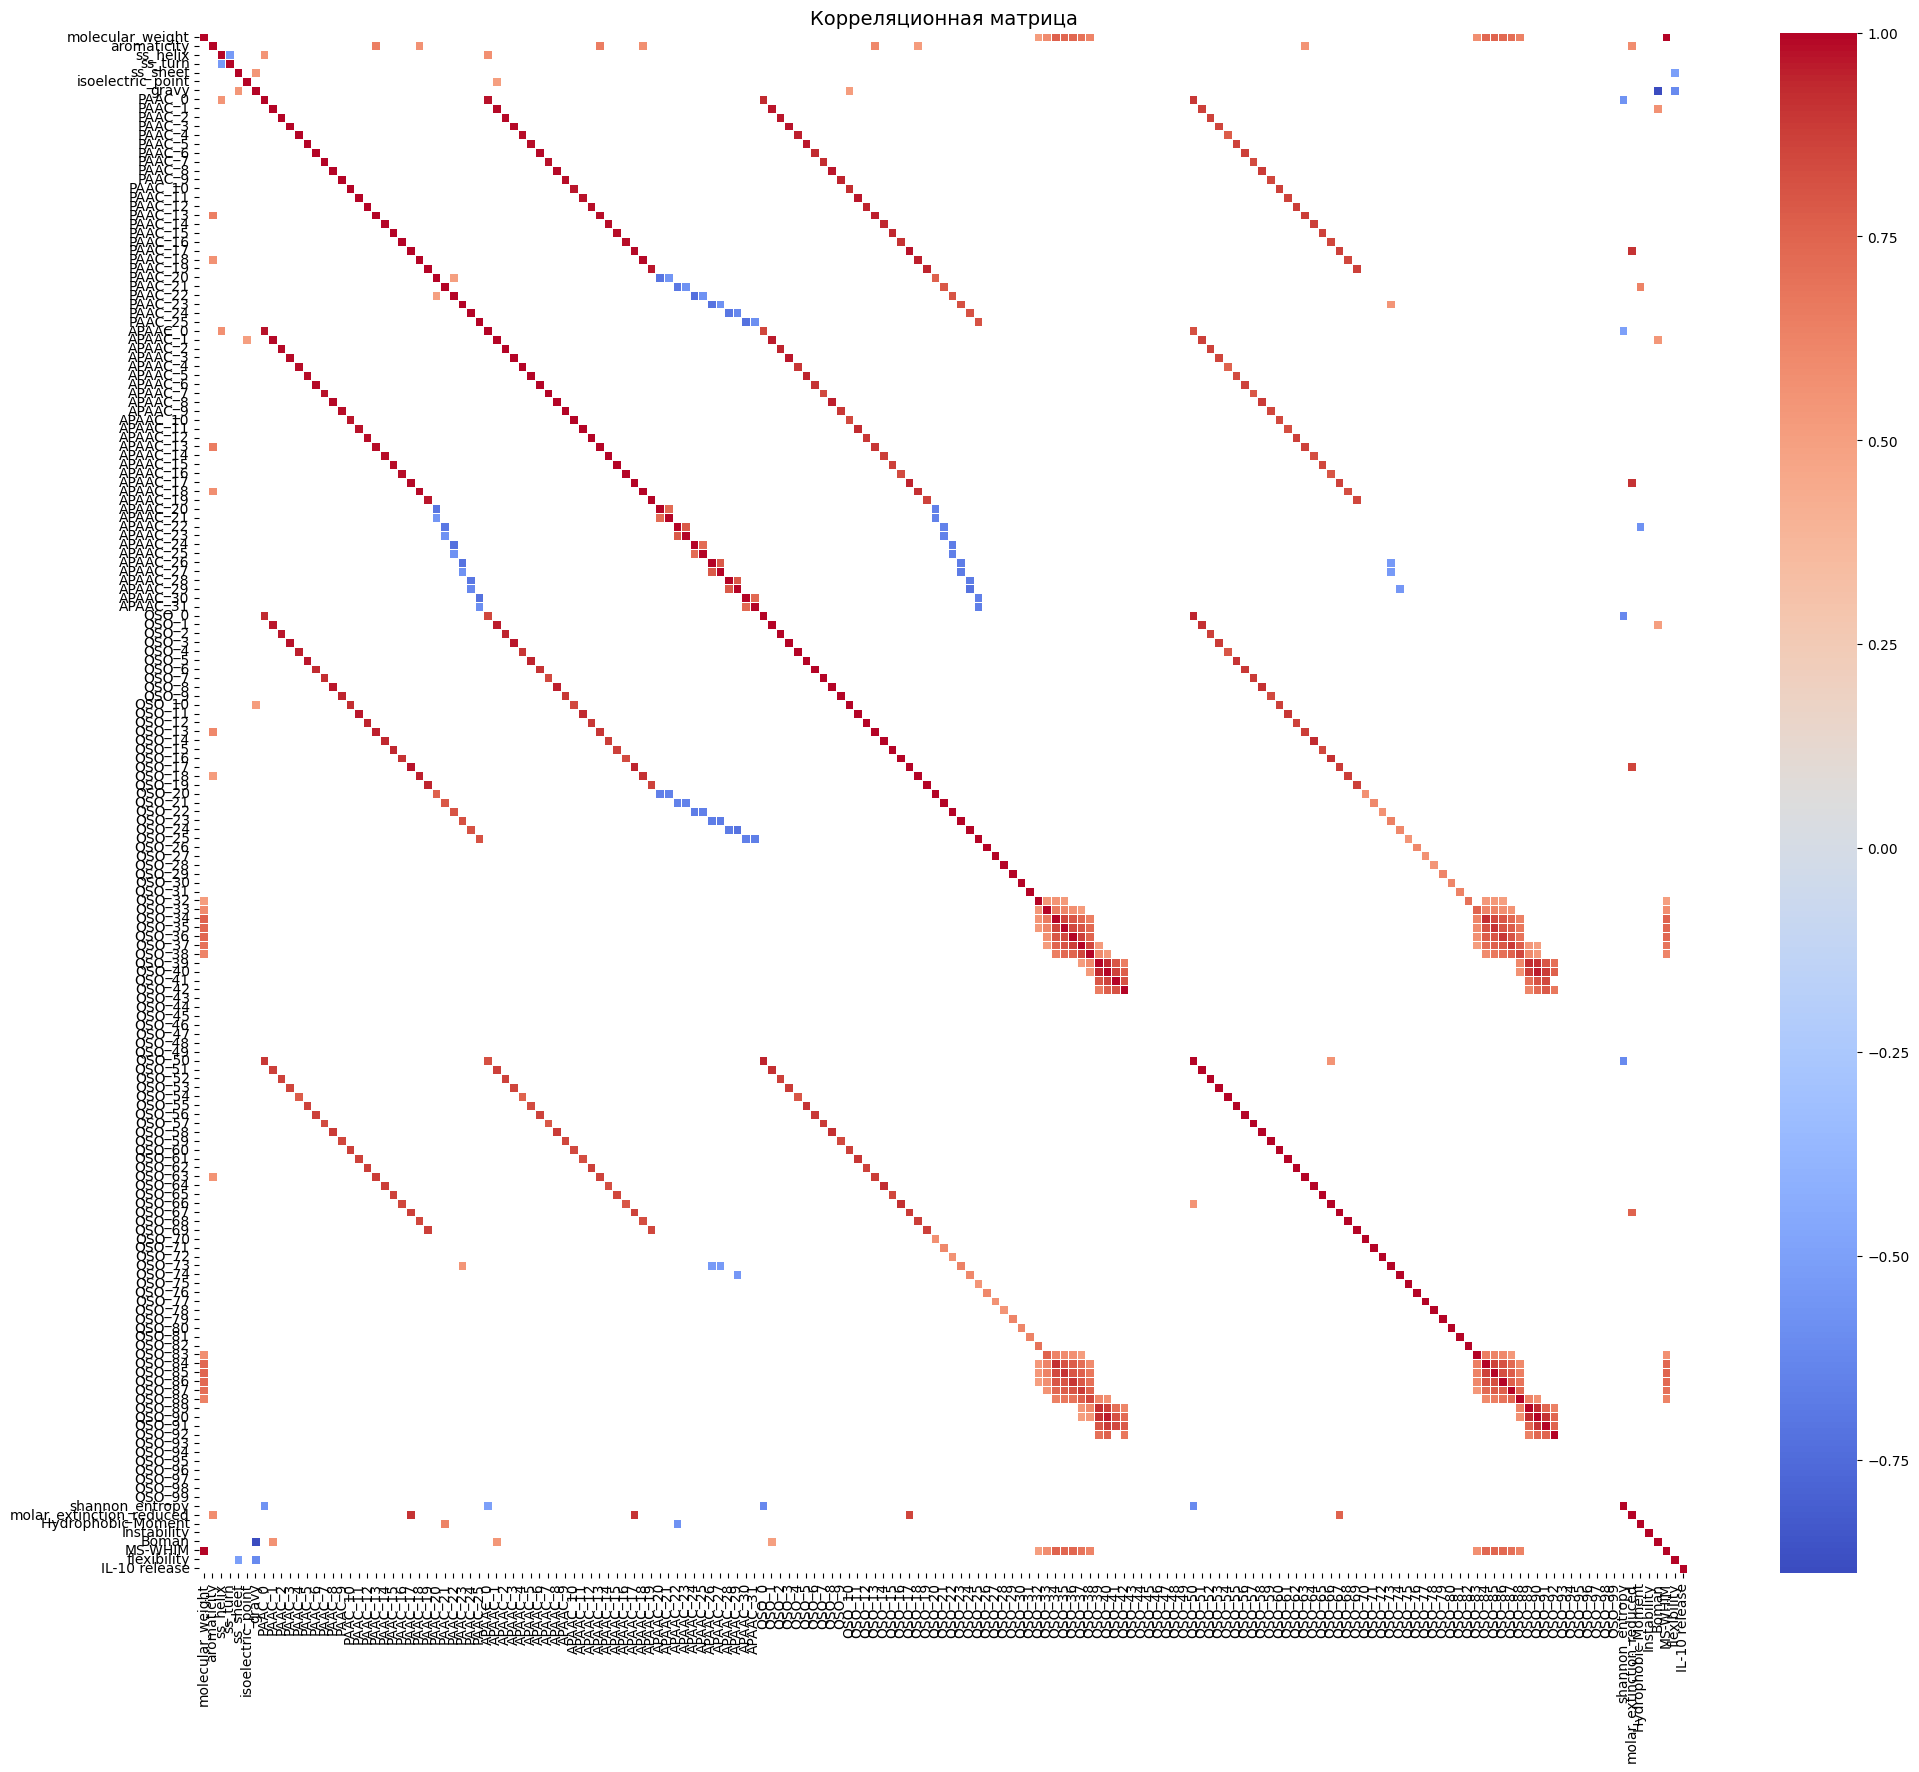

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix = train_df_reduced.corr()

filtered_corr = corr_matrix[(corr_matrix > 0.5) | (corr_matrix < -0.5)]

# Уменьшаем размер шрифтов и фигуры
plt.figure(figsize=(24, 20))
sns.heatmap(filtered_corr, annot=False, cmap="coolwarm", fmt=".2f",
            linewidths=0.5, cbar=True, xticklabels=True, yticklabels=True)

plt.title("Корреляционная матрица", fontsize=14)
plt.xticks(fontsize=10, rotation=90)  # Поворачиваем подписи
plt.yticks(fontsize=10)
plt.show()

In [341]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

class DataProcessor:
    def __init__(self, feature_importance_df=None, target_column='IL-10 release', variance_threshold=0.02,
                 corr_threshold=0.9, importance_threshold=0.0004):
        """
        Класс для предобработки данных:
        - Нормализация
        - Удаление скоррелированных признаков (оставляя более важный)
        - Удаление маловажных признаков по feature_importance

        :param feature_importance_df: DataFrame с важностью признаков (столбцы: 'Feature', 'Importance')
        :param target_column: Название таргета
        :param variance_threshold: Порог для удаления низковариативных признаков
        :param corr_threshold: Порог корреляции для удаления (оставляется более важный)
        :param importance_threshold: Минимальная важность признаков (фичи с меньшей удаляются)
        """
        self.target_column = target_column
        self.variance_threshold = variance_threshold
        self.corr_threshold = corr_threshold
        self.importance_threshold = importance_threshold
        self.scaler = MinMaxScaler()
        self.selector = VarianceThreshold(threshold=variance_threshold)
        self.feature_importance_df = feature_importance_df
        self.feature_to_drop_ = None
        self.low_variance_features_ = None
        self.low_importance_features_ = None

    def fit_transform(self, df, do_reduce=False):
        """Обрабатывает тренировочные данные и запоминает удаленные признаки."""
        df_without_target = df.drop([self.target_column], axis=1)

        # Масштабируем данные
        df_scaled = df_without_target

        if self.feature_importance_df is not None:
            important_features = self.feature_importance_df[
                self.feature_importance_df['Importance'] >= self.importance_threshold
            ]['Feature'].tolist()
            df_scaled = df_scaled[important_features]
            self.low_importance_features_ = list(set(df_without_target.columns) - set(important_features))


            corr_matrix = df_scaled.corr(method="spearman")
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

            to_drop = set()
            for column in upper.columns:
                if column in to_drop:
                    continue
                correlated_features = [index for index in upper.index if upper.loc[index, column] > self.corr_threshold]

                # Если есть скоррелированные, выбираем самый важный
                if correlated_features:
                    all_features = [column] + correlated_features
                    sorted_features = sorted(all_features, key=lambda x: self._get_feature_importance(x), reverse=True)
                    to_drop.update(sorted_features[1:])  # Удаляем все кроме самого важного

            self.feature_to_drop_ = list(to_drop)
            for column in df_scaled.columns:
                if len(df_scaled[column].value_counts()) == 1:
                    self.feature_to_drop_.append(column)

            df_scaled = df_scaled.drop(columns=self.feature_to_drop_)

            if do_reduce:
                self.selector.fit(df_scaled)
                self.low_variance_features_ = df_scaled.columns[~self.selector.get_support()]
                df_scaled = df_scaled.drop(columns=self.low_variance_features_)
                df_scaled.columns = [f"feature_{i}" for i in range(len(df_scaled.columns))]

        df_scaled[self.target_column] = df[self.target_column].to_list()
        return df_scaled

    def transform(self, df, do_reduce=False):
        """Применяет сохраненные преобразования к тестовым данным."""
        df_without_target = df.drop([self.target_column], axis=1)

        # Масштабируем данные
        df_scaled = df_without_target

        if self.feature_importance_df is not None:
            # Удаляем признаки, которые удаляли в train
            df_scaled = df_scaled.drop(columns=self.low_importance_features_, errors='ignore')
            df_scaled = df_scaled.drop(columns=self.feature_to_drop_, errors='ignore')

            if do_reduce:
                df_scaled = df_scaled.drop(columns=self.low_variance_features_, errors='ignore')
                df_scaled.columns = [f"feature_{i}" for i in range(len(df_scaled.columns))]

        df_scaled[self.target_column] = df[self.target_column].to_list()
        return df_scaled

    def _get_feature_importance(self, feature):
        """Возвращает важность признака, если его нет в feature_importance_df, то 0."""
        importance_dict = dict(zip(self.feature_importance_df['Feature'], self.feature_importance_df['Importance']))
        return importance_dict.get(feature, 0)



# Использование:
processor = DataProcessor(target_column=TARGET_NAME)

# Применяем к трейну
train_df_reduced = processor.fit_transform(train_df)

# Применяем к тесту (используем те же удаленные признаки)
test_df_reduced = processor.transform(test_df)


In [313]:
train_df_reduced

,Moreau-Broto_Auto_MBAuto_CIDH920105_1,Moreau-Broto_Auto_MBAuto_CIDH920105_2,Moreau-Broto_Auto_MBAuto_CIDH920105_3,Moreau-Broto_Auto_MBAuto_CIDH920105_4,Moreau-Broto_Auto_MBAuto_CIDH920105_5,Moreau-Broto_Auto_MBAuto_CIDH920105_6,Moreau-Broto_Auto_MBAuto_CIDH920105_7,Moreau-Broto_Auto_MBAuto_CIDH920105_8,Moreau-Broto_Auto_MBAuto_CIDH920105_9,Moreau-Broto_Auto_MBAuto_CIDH920105_10,...,QSO_99,shannon_entropy,molar_extinction_reduced,flexibility,instability_index,Hydrophobic Moment,Boman,MS-WHIM,IFNg release,IL-10 release
0,0.052586,0.107602,0.165454,0.271932,0.437479,0.588578,0.849816,1.287230,1.667607,1.963956,...,0.0,3.239098,0,1.021741,59.188889,0.440078,3.586111,1014.545236,0.0,1.0
1,0.073013,0.118453,0.180685,0.243500,0.372710,0.474580,0.474594,0.741879,1.252689,2.078812,...,0.0,3.189898,1490,1.013089,38.066667,0.446569,1.969333,830.954471,0.0,0.0
2,0.461405,0.904821,1.361863,1.837785,2.296789,2.745736,3.418948,4.375279,5.450154,6.772297,...,0.0,2.858459,0,1.022022,6.162500,0.293016,4.606875,960.013251,0.0,1.0
3,0.277079,0.659350,1.034084,1.397027,1.778584,2.167702,2.626678,3.192112,3.998377,4.792220,...,0.0,3.625000,0,1.003694,15.225000,0.406050,0.820625,836.458531,1.0,1.0
4,0.336238,0.766466,1.257792,1.863942,2.469072,3.310733,4.227452,5.246295,6.418325,8.297405,...,0.0,3.189898,0,1.000806,19.333333,0.463154,0.312667,862.474496,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,-0.257475,-0.609654,-0.947556,-1.224186,-1.513605,-1.868819,-2.278560,-2.763566,-3.424730,-4.115321,...,0.0,3.572431,2980,0.998353,11.883333,0.448731,0.909444,1061.570196,0.0,1.0
811,-0.357738,-0.642834,-1.098742,-1.532485,-2.056411,-2.712961,-3.436806,-4.268320,-5.378240,-7.069009,...,0.0,3.238901,0,0.985003,-21.961538,0.293419,1.520769,757.887216,0.0,1.0
812,0.141566,0.291212,0.461266,0.655329,0.829899,1.111197,1.319390,1.710763,2.033959,2.558047,...,0.0,3.522572,5500,0.980331,60.452381,0.528518,1.763333,1338.700921,1.0,1.0
813,-0.027840,-0.140901,-0.116901,-0.004301,0.185758,0.322459,0.480251,0.681034,0.928461,1.074794,...,0.0,3.189898,1490,0.961044,-5.826667,0.560156,0.312000,849.971611,1.0,1.0


In [330]:
%%time
import joblib
with joblib.parallel_backend('threading', n_jobs=1):
    out_of_fold_predictions = automl.fit_predict(train_df_sm, roles = roles, verbose = 1)

[22:19:23] Stdout logging level is INFO.
[22:19:23] Task: binary

[22:19:23] Start automl preset with listed constraints:
[22:19:23] - time: 900.00 seconds
[22:19:23] - CPU: 1 cores
[22:19:23] - memory: 16 GB

[22:19:23] Train data shape: (727, 1424)

[22:19:25] Layer 1 train process start. Time left 897.70 secs
[22:19:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:19:27] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9792134831460675
[22:19:27] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:19:27] Time left 895.91 secs

[22:19:31] Selector_LightGBM fitting and predicting completed
[22:19:34] Selector_LightGBM fitting and predicting completed
[22:19:36] Selector_LightGBM fitting and predicting completed
[22:19:36] Selector_LightGBM fitting and predicting completed
[22:19:36] Selector_LightGBM fitting and predicting completed
[22:19:36] Selector_LightGBM fitting and predicting completed
[22:19:36] Selector_LightGBM fitting and predicting completed
[22:1

Optimization Progress: 100%|██████████| 101/101 [00:30<00:00,  3.30it/s, best_trial=69, best_value=0.996]

[22:21:57] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[22:21:57] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[22:21:58] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9848477446669924
[22:21:58] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[22:21:58] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[22:21:59] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9826901156163491
[22:21:59] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[22:21:59] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, best_trial=61, best_value=0.993]

[22:22:28] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[22:22:28] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[22:22:29] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.978912229278619
[22:22:29] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[22:22:29] Time left 713.03 secs

[22:22:29] Layer 1 training completed.

[22:22:29] Blending: optimization starts with equal weights. Score = 0.9892526
[22:22:30] Blending: iteration 0: score = 0.9902866, weights = [0.35322678 0.24826166 0.2501547  0.         0.1483568 ]
[22:22:30] Blending: iteration 1: score = 0.9903680, weights = [0.39692542 0.207563   0.23545344 0.         0.16005814]
[22:22:30] Blending: no improvements for score. Terminated.

[22:22:30] Blending: best score = 0.9903680, best weights = [0.39692542 0.207563   0.23545344 0.         0.16005814]
[22:22:30] Automl preset training completed in 187.04 seconds

[22:22:30] Model description:
Final prediction for new objects (level 0) = 
	 0.39693 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.20756 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +

ROC-AUC: 0.7811437074829932
Precision: 0.6666666666666666
Recall: 0.71875
Matthews Correlation Coefficient: 0.550983127819047


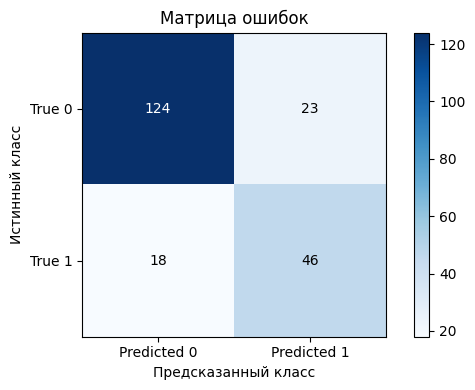

In [331]:
y_true = test_df_reduced[TARGET_NAME].copy()

test_df_reduced = test_df_reduced.drop(columns=[TARGET_NAME])

test_predictions = automl.predict(test_df_reduced)
test_predictions_flatten = test_predictions.data.flatten()

predicted_classes = (test_predictions_flatten > 0.5).astype(int)

roc_auc = roc_auc_score(y_true, predicted_classes)
precision = precision_score(y_true, predicted_classes)
recall = recall_score(y_true, predicted_classes)
mcc = matthews_corrcoef(y_true, predicted_classes)  # Вычисление коэффициента корреляции Мэттьюса

print("ROC-AUC:", roc_auc)
print("Precision:", precision)
print("Recall:", recall)
print("Matthews Correlation Coefficient:", mcc)

# 2. Строим матрицу ошибок с цветовым выделением
cm = confusion_matrix(y_true, predicted_classes)
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Добавляем подписи к осям и заголовок
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=["Predicted 0", "Predicted 1"],
       yticklabels=["True 0", "True 1"],
       ylabel='Истинный класс',
       xlabel='Предсказанный класс',
       title='Матрица ошибок')

# Вписываем значения в ячейки матрицы
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [333]:
test_df_reduced

,Moreau-Broto_Auto_MBAuto_CIDH920105_1,Moreau-Broto_Auto_MBAuto_CIDH920105_2,Moreau-Broto_Auto_MBAuto_CIDH920105_3,Moreau-Broto_Auto_MBAuto_CIDH920105_4,Moreau-Broto_Auto_MBAuto_CIDH920105_5,Moreau-Broto_Auto_MBAuto_CIDH920105_6,Moreau-Broto_Auto_MBAuto_CIDH920105_7,Moreau-Broto_Auto_MBAuto_CIDH920105_8,Moreau-Broto_Auto_MBAuto_CIDH920105_9,Moreau-Broto_Auto_MBAuto_CIDH920105_10,...,QSO_98,QSO_99,shannon_entropy,molar_extinction_reduced,flexibility,instability_index,Hydrophobic Moment,Boman,MS-WHIM,IL-10 release
2019,-0.075212,-0.217954,-0.442695,-0.631357,-0.953338,-1.444998,-1.915870,-2.360348,-2.768534,-3.388507,...,0.0,0.0,3.616875,0,0.997579,42.052941,0.577180,1.177059,967.506203,1.0
4310,0.007083,0.007341,-0.082719,-0.080106,-0.167957,-0.372411,-0.596804,-0.848323,-1.154464,-1.573698,...,0.0,0.0,3.030639,1490,0.988279,36.062500,0.415671,0.602500,886.483056,1.0
2069,0.029114,0.115296,0.045744,-0.018136,-0.093338,-0.170257,-0.393730,-0.826564,-1.610773,-2.334492,...,0.0,0.0,3.189898,0,1.009708,35.013333,0.464242,2.789333,880.963166,0.0
3837,-0.022510,-0.051976,-0.077325,-0.066656,-0.104672,-0.203543,-0.270446,-0.259794,-0.377294,-0.714590,...,0.0,0.0,2.927451,0,1.020728,-5.038889,0.631507,1.430556,1007.119511,0.0
41283,0.003499,-0.007715,-0.045734,-0.039411,-0.025682,-0.005863,0.065737,0.071021,0.015452,0.023589,...,0.0,0.0,3.708132,1490,0.991403,4.626087,0.513665,3.110435,1352.205733,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21295,-0.056704,-0.190668,-0.356404,-0.553583,-0.791640,-1.097468,-1.339691,-1.877703,-2.563478,-3.485675,...,0.0,0.0,2.573557,11000,0.971673,18.966667,0.172076,-0.748000,733.346561,1.0
21282,-0.438234,-1.061071,-1.907129,-2.805151,-3.757598,-4.753418,-6.146425,-7.758369,-9.647060,-12.587048,...,0.0,0.0,2.923231,2980,0.973825,29.353333,0.310979,0.953333,901.401401,1.0
21636,-0.123554,-0.309480,-0.449093,-0.612526,-0.799084,-1.004785,-1.244890,-1.581371,-2.018598,-2.480460,...,0.0,0.0,3.550341,6990,0.975862,53.863636,0.265649,0.026818,1289.160553,1.0
21629,-0.333562,-0.721427,-1.185138,-1.670636,-2.197128,-2.735478,-3.288423,-3.886439,-4.491320,-5.106247,...,0.0,0.0,3.346439,6990,0.983227,85.230000,0.299126,2.839000,1278.644115,1.0


In [335]:
import joblib
test_df_reduced[TARGET_NAME] = y_true
# accurate feature importances calculation
with joblib.parallel_backend('threading', n_jobs=12):
    features = automl.get_feature_scores('accurate', test_df_reduced, silent=False)

# not_important_features = features[features['Importance'] < 20]['Feature']

In [336]:
features.to_csv('/Users/rleontiev/Downloads/Telegram Desktop/feature_importance.csv')

<Axes: xlabel='Feature'>

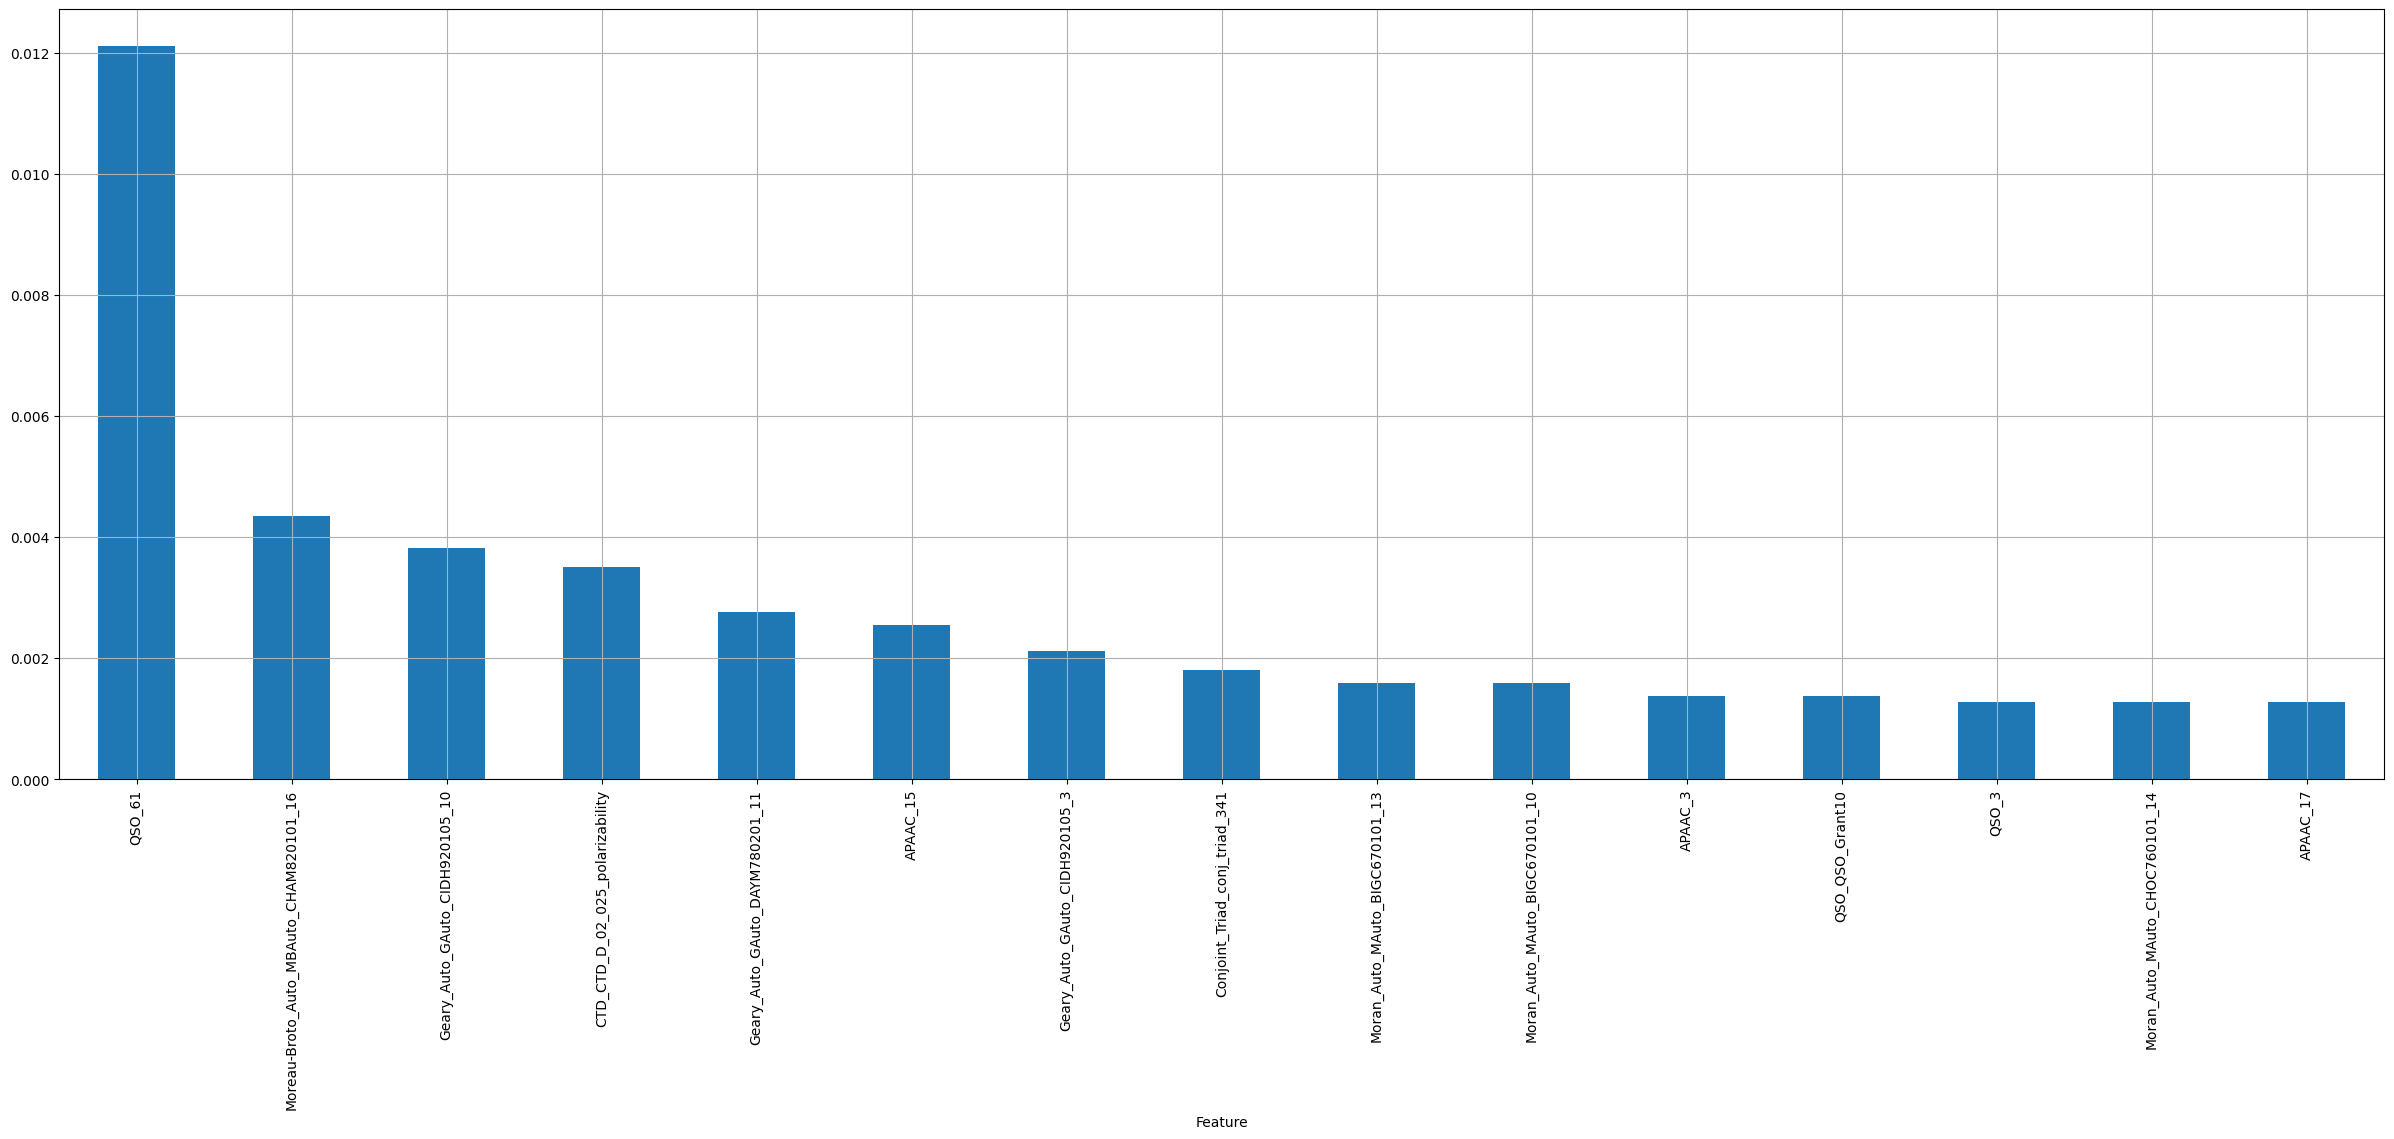

In [337]:
features.head(15).set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [354]:
features = pd.read_csv('/Users/rleontiev/Downloads/features_il10.csv')['feature'].to_list()

In [355]:
features

['PAAC_15',
 'CTD_CTD_D_03_001_normalized_vdwv',
 'PAAC_10',
 'APAAC_17',
 'CTD_CTD_T_12_normalized_vdwv',
 'Conjoint_Triad_conj_triad_222',
 'CTD_CTD_D_01_025_polarity',
 'Geary_Auto_GAuto_CIDH920105_3',
 'CTD_CTD_D_03_025_polarity',
 'CTD_CTD_D_03_100_charge',
 'CTD_CTD_C_02_polarizability',
 'Conjoint_Triad_conj_triad_153',
 'Geary_Auto_GAuto_CHAM810101_13',
 'shannon_entropy',
 'Conjoint_Triad_conj_triad_664',
 'CTD_CTD_C_03_solvent_accessibility',
 'APAAC_3',
 'Conjoint_Triad_conj_triad_325',
 'Conjoint_Triad_conj_triad_636',
 'Conjoint_Triad_conj_triad_363',
 'Conjoint_Triad_conj_triad_344',
 'Conjoint_Triad_conj_triad_272',
 'Conjoint_Triad_conj_triad_176',
 'CTD_CTD_D_03_075_charge',
 'CTD_CTD_C_03_secondary_struct',
 'ss_sheet',
 'Geary_Auto_GAuto_BIGC670101_7',
 'Conjoint_Triad_conj_triad_545',
 'Conjoint_Triad_conj_triad_563',
 'Conjoint_Triad_conj_triad_722',
 'CTD_CTD_T_13_polarity',
 'Geary_Auto_GAuto_DAYM780201_4',
 'Geary_Auto_GAuto_CIDH920105_10',
 'APAAC_27',
 'Geary_

In [ ]:
# Использование:
processor = DataProcessor(target_column=TARGET_NAME, feature_importance_df=features, importance_threshold=0.0006)

# Применяем к трейну
train_df_without_bad_features = processor.fit_transform(train_df)

# Применяем к тесту (используем те же удаленные признаки)
test_df_without_bad_features = processor.transform(test_df)

In [356]:
train_df_without_bad_features = train_df[features]

In [357]:
train_df_without_bad_features

,PAAC_15,CTD_CTD_D_03_001_normalized_vdwv,PAAC_10,APAAC_17,CTD_CTD_T_12_normalized_vdwv,Conjoint_Triad_conj_triad_222,CTD_CTD_D_01_025_polarity,Geary_Auto_GAuto_CIDH920105_3,CTD_CTD_D_03_025_polarity,CTD_CTD_D_03_100_charge,...,CTD_CTD_T_13_polarity,Geary_Auto_GAuto_DAYM780201_4,Geary_Auto_GAuto_CIDH920105_10,APAAC_27,Geary_Auto_GAuto_CHOC760101_12,Conjoint_Triad_conj_triad_742,Moran_Auto_MAuto_CIDH920105_13,Moran_Auto_MAuto_DAYM780201_12,CTD_CTD_D_03_025_solvent_accessibility,IL-10 release
3865,3.279,22.222,3.279,0.000,0.353,0,83.333,0.619979,22.222,50.000,...,0.118,0.226881,0.562993,1.275,0.185054,0,-0.416510,0.505123,55.556,1.0
3526,4.645,20.000,4.645,0.000,0.429,0,13.333,0.686871,60.000,26.667,...,0.000,0.198767,1.221241,0.477,0.629424,0,0.352385,-0.146510,53.333,0.0
17234,8.619,46.667,4.310,0.000,0.214,0,33.333,1.282960,46.667,6.667,...,0.286,0.767100,1.105601,2.178,2.409314,0,-1.187822,-0.128236,26.667,1.0
3031,4.215,12.500,8.429,0.000,0.267,0,62.500,0.287023,12.500,93.750,...,0.133,0.284659,0.233454,0.472,0.160676,0,-0.191825,-0.188077,56.250,1.0
1841,4.117,37.500,8.234,0.000,0.267,0,18.750,0.883021,75.000,6.250,...,0.067,0.406001,0.362246,-0.836,0.464423,0,-0.403222,0.689609,12.500,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22948,3.521,27.778,3.521,0.000,0.118,0,27.778,0.690033,66.667,16.667,...,0.118,1.434103,0.815424,2.365,0.604154,0,-0.149930,0.112949,27.778,0.0
23002,5.129,15.385,0.000,0.000,0.250,0,30.769,1.249734,38.462,7.692,...,0.167,0.532587,1.001699,1.513,0.598765,0,0.000000,1.093765,53.846,1.0
41281,2.941,4.762,8.823,4.626,0.100,1,9.524,1.118586,19.048,61.905,...,0.050,0.476721,1.202472,2.302,0.534967,0,0.760725,-0.219637,19.048,0.0
41279,8.980,20.000,4.490,0.000,0.071,0,20.000,0.448859,33.333,0.000,...,0.429,0.218419,0.835458,0.492,2.102683,0,-0.696686,0.221577,6.667,0.0


In [364]:
pseudo_df = pd.read_csv('./Telegram Desktop/pseudo_label_il_10.csv')

In [365]:
pseudo_df

,Unnamed: 0,PAAC_15,CTD_CTD_D_03_001_normalized_vdwv,PAAC_10,APAAC_17,CTD_CTD_T_12_normalized_vdwv,Conjoint_Triad_conj_triad_222,CTD_CTD_D_01_025_polarity,Geary_Auto_GAuto_CIDH920105_3,CTD_CTD_D_03_025_polarity,...,CTD_CTD_T_13_polarity,Geary_Auto_GAuto_DAYM780201_4,Geary_Auto_GAuto_CIDH920105_10,APAAC_27,Geary_Auto_GAuto_CHOC760101_12,Conjoint_Triad_conj_triad_742,Moran_Auto_MAuto_CIDH920105_13,Moran_Auto_MAuto_DAYM780201_12,CTD_CTD_D_03_025_solvent_accessibility,IL-10 release
0,30,9.627,66.667,0.000,0.000,0.143,0,100.000,0.121694,86.667,...,0.000,0.221378,0.237336,0.025,0.750561,0,-0.061587,0.595042,33.333,0
1,59,3.729,53.333,3.729,6.979,0.214,0,53.333,0.523426,60.000,...,0.071,0.443050,0.386895,1.094,0.931781,0,-0.358765,0.411042,93.333,0
2,62,0.000,13.333,0.000,0.000,0.357,0,26.667,1.424472,86.667,...,0.143,0.520497,1.858155,3.348,2.509637,0,0.037040,-0.043605,13.333,0
3,118,3.973,26.667,3.973,6.897,0.286,0,20.000,0.579587,26.667,...,0.071,1.343026,0.213914,1.691,2.739893,0,-0.602010,0.058324,13.333,0
4,119,3.392,68.421,10.175,0.000,0.278,0,21.053,0.578674,89.474,...,0.167,0.513782,1.734948,-1.837,0.707466,0,-0.476817,0.621636,68.421,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,31659,3.619,5.263,7.239,0.000,0.222,0,21.053,0.950518,5.263,...,0.167,0.273809,1.194805,0.620,0.525833,0,-0.675839,0.199203,31.579,1
1236,31686,3.302,5.556,6.603,0.000,0.235,0,16.667,1.053031,88.889,...,0.176,1.343461,0.906327,-2.423,0.480292,0,0.001831,0.034021,16.667,1
1237,31690,3.525,11.765,7.051,0.000,0.250,0,11.765,1.154174,88.235,...,0.125,1.435340,1.054640,-2.508,0.559108,0,0.147632,0.145801,11.765,1
1238,31691,0.000,14.286,9.439,0.000,0.231,0,28.571,1.503208,14.286,...,0.000,0.927808,1.684509,-1.111,0.437471,0,-1.239843,0.224787,42.857,1


In [366]:
pseudo_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
train_df_without_bad_features_with_pseudo = pd.concat([train_df_without_bad_features, pseudo_df], axis=0)

In [372]:
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
%%time
out_of_fold_predictions = automl.fit_predict(train_df_without_bad_features_with_pseudo, roles = roles, verbose = 1)

[23:52:44] Stdout logging level is INFO.
[23:52:44] Task: binary

[23:52:44] Start automl preset with listed constraints:
[23:52:44] - time: 900.00 seconds
[23:52:44] - CPU: 1 cores
[23:52:44] - memory: 16 GB

[23:52:44] Train data shape: (2082, 40)

[23:52:44] Layer 1 train process start. Time left 899.86 secs
[23:52:45] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:52:45] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9768101963223914
[23:52:45] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:52:45] Time left 899.44 secs

[23:52:45] Selector_LightGBM fitting and predicting completed
[23:52:45] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:52:48] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9756420975933172
[23:52:48] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:52:48] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 176.77 secs


Optimization Progress: 100%|██████████| 101/101 [00:48<00:00,  2.07it/s, best_trial=62, best_value=0.985]

[23:53:36] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[23:53:36] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[23:53:37] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9749343895685358
[23:53:37] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[23:53:37] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[23:53:38] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9747137064210236
[23:53:38] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[23:53:38] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [00:27<00:00,  3.71it/s, best_trial=15, best_value=0.984]

[23:54:05] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[23:54:05] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[23:54:06] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9653926971000142
[23:54:06] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[23:54:06] Time left 817.87 secs

[23:54:06] Layer 1 training completed.

[23:54:06] Blending: optimization starts with equal weights. Score = 0.9793442
[23:54:06] Blending: iteration 0: score = 0.9804657, weights = [0.2990621  0.24584974 0.10172443 0.2999872  0.05337659]
[23:54:06] Blending: iteration 1: score = 0.9806227, weights = [0.23329408 0.29143775 0.23920025 0.23606798 0.        ]
[23:54:07] Blending: iteration 2: score = 0.9806874, weights = [0.301705   0.24152796 0.22988868 0.22687835 0.        ]
[23:54:07] Blending: iteration 3: score = 0.9806931, weights = [0.298505   0.21773812 0.27357778 0.2101791  0.        ]
[23:54:07] Blending: no improvements for score. Terminated.

[23:54:07] Blending: best score = 0.9806931, best weights = [0.298505   0.21773812 0.27357778 0.2101791  0.        ]
[23:54:07] Automl pre

In [361]:
test_df_without_bad_features = test_df[train_df_without_bad_features.columns.to_list()]

In [362]:
test_df_without_bad_features

,PAAC_15,CTD_CTD_D_03_001_normalized_vdwv,PAAC_10,APAAC_17,CTD_CTD_T_12_normalized_vdwv,Conjoint_Triad_conj_triad_222,CTD_CTD_D_01_025_polarity,Geary_Auto_GAuto_CIDH920105_3,CTD_CTD_D_03_025_polarity,CTD_CTD_D_03_100_charge,...,CTD_CTD_T_13_polarity,Geary_Auto_GAuto_DAYM780201_4,Geary_Auto_GAuto_CIDH920105_10,APAAC_27,Geary_Auto_GAuto_CHOC760101_12,Conjoint_Triad_conj_triad_742,Moran_Auto_MAuto_CIDH920105_13,Moran_Auto_MAuto_DAYM780201_12,CTD_CTD_D_03_025_solvent_accessibility,IL-10 release
2019,0.000,41.176,6.801,0.000,0.312,1,11.765,1.244233,47.059,64.706,...,0.062,0.385829,0.501611,-0.068,0.235866,0,0.183264,0.023022,100.000,1.0
4310,0.000,37.500,8.333,0.000,0.400,0,18.750,0.546993,43.750,87.500,...,0.067,0.397490,0.966878,-0.664,0.020497,0,-0.474459,0.340649,62.500,1.0
2069,12.863,6.667,0.000,0.000,0.357,0,6.667,1.243098,100.000,0.000,...,0.071,0.876490,1.108296,-0.327,0.181368,0,0.049144,0.039489,26.667,0.0
3837,0.000,27.778,10.250,0.000,0.412,0,5.556,0.981578,27.778,77.778,...,0.235,0.376913,1.555155,5.161,0.494237,0,0.036120,-0.144058,61.111,0.0
41283,2.607,4.348,7.820,0.000,0.318,0,17.391,0.790734,4.348,39.130,...,0.136,0.855930,0.468955,1.169,0.823496,0,-0.140914,0.141472,17.391,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21295,8.104,13.333,4.052,11.995,0.071,0,13.333,1.150902,0.000,0.000,...,0.000,2.385251,0.396299,0.603,4.419344,0,-0.135815,-0.460874,66.667,1.0
21282,8.136,13.333,8.136,0.000,0.357,0,13.333,1.298968,0.000,100.000,...,0.000,1.215899,0.716295,-1.133,0.976355,0,-0.229832,0.092411,6.667,1.0
21636,0.000,22.727,6.058,4.492,0.190,0,22.727,0.865656,81.818,0.000,...,0.095,1.136072,0.545805,-0.504,0.758695,0,0.182581,0.617665,22.727,1.0
21629,8.694,20.000,11.592,4.984,0.263,0,15.000,1.105226,70.000,35.000,...,0.211,1.790062,0.890971,-0.997,1.226970,0,0.000488,-0.051020,10.000,1.0


ROC-AUC: 0.7706738945578231
Precision: 0.7959183673469388
Recall: 0.609375
Matthews Correlation Coefficient: 0.5893448252076117


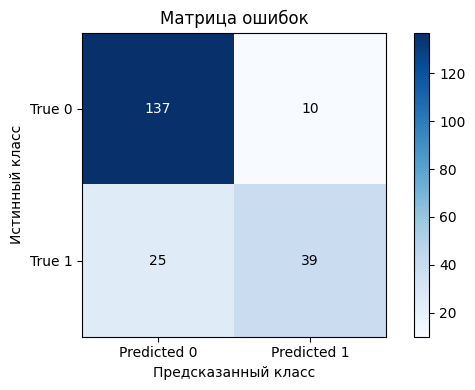

In [378]:
# y_true = test_df_without_bad_features[TARGET_NAME].copy()

# test_df_without_bad_features = test_df_without_bad_features.drop(columns=[TARGET_NAME])

test_predictions = automl.predict(test_df_without_bad_features)
test_predictions_flatten = test_predictions.data.flatten()

predicted_classes = (test_predictions_flatten > 0.5).astype(int)

roc_auc = roc_auc_score(y_true, predicted_classes)
precision = precision_score(y_true, predicted_classes)
recall = recall_score(y_true, predicted_classes)
mcc = matthews_corrcoef(y_true, predicted_classes)  # Вычисление коэффициента корреляции Мэттьюса

print("ROC-AUC:", roc_auc)
print("Precision:", precision)
print("Recall:", recall)
print("Matthews Correlation Coefficient:", mcc)

# 2. Строим матрицу ошибок с цветовым выделением
cm = confusion_matrix(y_true, predicted_classes)
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Добавляем подписи к осям и заголовок
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=["Predicted 0", "Predicted 1"],
       yticklabels=["True 0", "True 1"],
       ylabel='Истинный класс',
       xlabel='Предсказанный класс',
       title='Матрица ошибок')

# Вписываем значения в ячейки матрицы
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [244]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.42307 * 5 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.38599 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.18928 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.31690 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.10783 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


	    Model #1.
		Final prediction for new objects (level 0) = 
			 0.44303 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.05557 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.24951 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.25189 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	    Model #2.
		Final prediction for new objects (level 0) = 
			 0.33384 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.12944 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM

In [104]:
import joblib

# Сохранение модели в файл
joblib.dump(automl, "/Users/rleontiev/Downloads/Telegram Desktop/model_all_features_acc_importance_63.pkl")

['/Users/rleontiev/Downloads/Telegram Desktop/model_all_features_acc_importance_63.pkl']

In [ ]:
import joblib

# Загрузка модели из файла
automl_il2 = joblib.load("/Users/rleontiev/Downloads/Telegram Desktop/il2_model_pos_features.pkl")
automl_il4 = joblib.load("/Users/rleontiev/Downloads/Telegram Desktop/il_4_LightAutoML_feature_selection_corr_importance_accurate.pkl")
automl_il10 = automl

features_il2 = pd.read_csv('/Users/rleontiev/Downloads/Telegram Desktop/il2_pos_features.csv')
features_il4 = pd.read_csv('/Users/rleontiev/Downloads/Telegram Desktop/IL-4_feature_importance_accurate.csv')
# features_il10 = pd.read_csv('')

In [ ]:


processor = DataProcessor(target_column=TARGET_NAME, feature_importance_df=features_il4)

# Применяем к трейну
train_df_without_bad_features = processor.fit_transform(train_df)

In [99]:
threshold = 0
pseudo_label_df = pd.read_csv('/Users/rleontiev/Downloads/Telegram Desktop/human_mhc2_epitopes_processed_epitope_features.csv')
pseudo_label_df_lil = pd.read_csv('/Users/rleontiev/Downloads/Telegram Desktop/unlabeled_with_descriptors_4.csv')
pseudo_label_df = pd.merge(pseudo_label_df_lil, pseudo_label_df, on="Epitope ID")


In [58]:
pseudo_label_df

,Unnamed: 0,Epitope ID,Epitope Seq,molecular_weight,aromaticity,ss_helix,ss_turn,ss_sheet,isoelectric_point,gravy,...,SOCN_All_SOCN_Grant2,SOCN_All_SOCN_Grant3,SOCN_All_SOCN_Grant4,SOCN_All_SOCN_Grant5,SOCN_All_SOCN_Grant6,SOCN_All_SOCN_Grant7,SOCN_All_SOCN_Grant8,SOCN_All_SOCN_Grant9,SOCN_All_SOCN_Grant10,SOCN
0,0,1901661,KAFKQKQKEEQKKLE,1890.1880,0.066667,0.733333,0.000000,0.133333,9.701025,-2.400000,...,4.656,3.642,3.667,3.631,3.639,3.002,3.230,1.267,3.555,7.014
1,1,1081215,PLATGGIKKSGKK,1284.5479,0.000000,0.461538,0.384615,0.230769,10.481479,-0.753846,...,5.362,4.016,2.587,2.506,3.352,3.268,2.554,1.937,1.733,3.092
2,2,234244,QTFPHQSQQAFPQPQ,1768.8821,0.133333,0.066667,0.266667,0.200000,6.741127,-1.540000,...,2.803,2.280,2.524,1.795,1.674,1.263,0.778,1.459,1.199,2.938
3,3,234215,QPFPQPQQPQRPFPQ,1820.0150,0.133333,0.000000,0.400000,0.133333,9.750021,-1.966667,...,3.026,2.490,2.248,1.861,1.857,1.624,1.576,1.568,1.000,2.947
4,4,234195,PQQPEQIIPQQPQQP,1755.9249,0.000000,0.066667,0.333333,0.133333,4.050028,-1.800000,...,2.437,1.980,1.948,1.345,1.266,0.974,0.454,0.610,0.651,1.806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363110,363135,2070466,RTVLVIAHRLQAVQ,1603.9099,0.000000,0.285714,0.000000,0.500000,11.999968,0.600000,...,4.214,4.109,4.463,3.649,3.252,1.639,0.631,1.158,0.651,3.398
363111,363136,2062620,DRTVLVIAHRLQAVQ,1718.9973,0.000000,0.266667,0.066667,0.466667,9.605290,0.326667,...,4.636,4.744,5.170,4.284,3.970,2.170,0.820,1.245,1.358,3.485
363112,363137,2065141,GDRTVLVIAHRLQAVQ,1776.0486,0.000000,0.250000,0.125000,0.437500,9.605290,0.281250,...,5.636,4.818,5.385,4.633,4.185,2.521,0.863,1.837,2.358,4.087
363113,363138,2062621,DRTVLVIAHRLQAVQR,1875.1830,0.000000,0.250000,0.062500,0.437500,11.699029,0.025000,...,5.636,5.744,6.170,5.284,3.970,2.656,1.820,2.245,2.358,4.485


In [55]:
len(features_il2['0'].to_list())

150

In [ ]:
train_df_without_bad_features.columns

In [245]:
pd.DataFrame({'feature': train_df_without_bad_features.columns.to_list()}).to_csv('/Users/rleontiev/Downloads/features_il10.csv')

In [103]:
len_div_3 = len(pseudo_label_df) // 3
pseudo_label_df_il2 = pseudo_label_df[:len_div_3][features_il2['0'].to_list()]
pseudo_label_df_il4 = pseudo_label_df[len_div_3:2 * len_div_3]
pseudo_label_df_il10 = pseudo_label_df[2 * len_div_3:][train_df_without_bad_features.drop('IL-10 release', axis=1).columns.to_list()]


In [106]:
pseudo_label_df_il10

,PAAC_15,CTD_CTD_D_03_001_normalized_vdwv,PAAC_10,APAAC_17,CTD_CTD_T_12_normalized_vdwv,Conjoint_Triad_conj_triad_222,CTD_CTD_D_01_025_polarity,Geary_Auto_GAuto_CIDH920105_3,CTD_CTD_D_03_025_polarity,CTD_CTD_D_03_100_charge,...,Conjoint_Triad_conj_triad_722,CTD_CTD_T_13_polarity,Geary_Auto_GAuto_DAYM780201_4,Geary_Auto_GAuto_CIDH920105_10,APAAC_27,Geary_Auto_GAuto_CHOC760101_12,Conjoint_Triad_conj_triad_742,Moran_Auto_MAuto_CIDH920105_13,Moran_Auto_MAuto_DAYM780201_12,CTD_CTD_D_03_025_solvent_accessibility
242076,0.000,30.769,13.521,0.0,0.500,1,76.923,1.206,92.308,100.000,...,0,0.000,1.204,0.369,-0.105,0.449,0,0.00000,0.61745,61.538
242077,0.000,28.571,12.022,0.0,0.462,1,71.429,1.190,100.000,92.857,...,0,0.000,1.209,0.297,-0.870,1.729,0,-0.83327,0.56373,57.143
242078,0.000,31.250,7.947,0.0,0.400,1,31.250,0.966,0.000,93.750,...,0,0.000,1.374,0.889,-2.167,0.586,0,-0.92467,0.62064,18.750
242079,4.519,35.714,9.037,0.0,0.385,0,21.429,0.868,78.571,42.857,...,0,0.000,0.545,0.981,-0.103,1.321,0,-0.68948,0.67556,28.571
242080,8.134,25.000,8.134,0.0,0.400,0,62.500,1.045,93.750,100.000,...,0,0.000,0.635,0.401,-1.092,1.644,0,-0.20795,-0.15955,18.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363110,0.000,7.143,8.247,0.0,0.308,0,21.429,0.826,64.286,0.000,...,0,0.077,1.033,0.826,-1.550,1.459,0,-0.31264,0.08084,57.143
363111,0.000,13.333,7.633,0.0,0.286,0,26.667,0.919,66.667,6.667,...,0,0.071,1.325,1.114,-2.205,1.219,0,-0.79307,0.17820,60.000
363112,0.000,18.750,7.179,0.0,0.267,0,31.250,0.851,68.750,12.500,...,0,0.067,1.203,0.943,-2.023,1.547,0,-0.82569,0.05856,62.500
363113,0.000,12.500,6.983,0.0,0.267,0,25.000,0.894,12.500,6.250,...,0,0.067,1.341,1.183,-1.753,1.319,0,-0.77921,0.13766,56.250


In [111]:
pseudo_label_df_il10

AssertionError: Numpy dataset support only np.ndarray features

AssertionError: Numpy dataset support only np.ndarray features

In [ ]:
pred = automl.predict(pseudo_label_df_il10)


In [131]:
pseudo_label_df_il10['predict'] = list(automl.predict(pseudo_label_df_il10).data.flatten())

In [210]:
CONFIDENCE_THRESHOLD = 0.918

# Фильтрация данных: оставляем только примеры, где модель уверена
pseudo_label_df_il10_confident = pseudo_label_df_il10[(pseudo_label_df_il10["predict"] >= CONFIDENCE_THRESHOLD) | (pseudo_label_df_il10["predict"] <= (1 - CONFIDENCE_THRESHOLD))]

In [214]:
train_df_without_bad_features1 = pd.concat([train_df_without_bad_features, df_selected], axis=0)

In [142]:
train_df_without_bad_features1

,PAAC_15,CTD_CTD_D_03_001_normalized_vdwv,PAAC_10,APAAC_17,CTD_CTD_T_12_normalized_vdwv,Conjoint_Triad_conj_triad_222,CTD_CTD_D_01_025_polarity,Geary_Auto_GAuto_CIDH920105_3,CTD_CTD_D_03_025_polarity,CTD_CTD_D_03_100_charge,...,Geary_Auto_GAuto_DAYM780201_4,Geary_Auto_GAuto_CIDH920105_10,APAAC_27,Geary_Auto_GAuto_CHOC760101_12,Conjoint_Triad_conj_triad_742,Moran_Auto_MAuto_CIDH920105_13,Moran_Auto_MAuto_DAYM780201_12,CTD_CTD_D_03_025_solvent_accessibility,IL-10 release,predict
3865,3.279,22.222,3.279,0.000,0.353,0,83.333,0.619979,22.222,50.000,...,0.226881,0.562993,1.275,0.185054,0,-0.416510,0.505123,55.556,1.0,NaN
3526,4.645,20.000,4.645,0.000,0.429,0,13.333,0.686871,60.000,26.667,...,0.198767,1.221241,0.477,0.629424,0,0.352385,-0.146510,53.333,0.0,NaN
17234,8.619,46.667,4.310,0.000,0.214,0,33.333,1.282960,46.667,6.667,...,0.767100,1.105601,2.178,2.409314,0,-1.187822,-0.128236,26.667,1.0,NaN
3031,4.215,12.500,8.429,0.000,0.267,0,62.500,0.287023,12.500,93.750,...,0.284659,0.233454,0.472,0.160676,0,-0.191825,-0.188077,56.250,1.0,NaN
1841,4.117,37.500,8.234,0.000,0.267,0,18.750,0.883021,75.000,6.250,...,0.406001,0.362246,-0.836,0.464423,0,-0.403222,0.689609,12.500,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,0.000,11.111,3.532,0.000,0.176,0,27.778,1.427000,11.111,44.444,...,0.803000,1.177000,-1.336,0.635000,0,-0.023960,-0.070780,100.000,1.0,0.900034
2734,0.000,23.077,9.672,0.000,0.417,0,15.385,0.972000,76.923,7.692,...,0.681000,1.111000,0.306,0.366000,0,0.000000,0.712210,53.846,1.0,0.900021
2735,0.000,8.000,4.625,0.000,0.167,0,16.000,1.317000,8.000,96.000,...,1.042000,1.032000,0.173,1.375000,0,-0.248510,0.120460,72.000,1.0,0.900006
2736,4.787,14.286,4.787,6.995,0.154,0,35.714,0.529000,14.286,21.429,...,1.599000,1.056000,-1.768,0.356000,0,-1.814080,0.203500,64.286,1.0,0.900005


In [211]:
pseudo_label_df_il10_confident[TARGET_NAME] = (pseudo_label_df_il10_confident['predict'] > 0.5).astype(int)

/var/folders/3m/ml853yhj7m1gwt_yly8mfyd40000gp/T/ipykernel_76283/2725214734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudo_label_df_il10_confident[TARGET_NAME] = (pseudo_label_df_il10_confident['predict'] > 0.5).astype(int)


In [212]:
min_class_size = pseudo_label_df_il10_confident[TARGET_NAME].value_counts().min()  # Определяем минимальное кол-во примеров
df_selected = pseudo_label_df_il10_confident.groupby(TARGET_NAME).apply(lambda x: x.nlargest(min_class_size, "predict")).reset_index(drop=True)

/var/folders/3m/ml853yhj7m1gwt_yly8mfyd40000gp/T/ipykernel_76283/1175413480.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_selected = pseudo_label_df_il10_confident.groupby(TARGET_NAME).apply(lambda x: x.nlargest(min_class_size, "predict")).reset_index(drop=True)


In [213]:
df_selected[TARGET_NAME].value_counts()

IL-10 release
0    117
1    117
Name: count, dtype: int64

In [137]:
train_df[TARGET_NAME].value_counts()

IL-10 release
0.0    588
1.0    254
Name: count, dtype: int64